# Training of model for identification of molecular structure from mass spectrum
This notebook demonstrates the training and identification of our models.
Before running this notebook, you need to run DataFetch.ipynb Preprocess.ipynb train.ipynb

In [18]:
# import the depending library.

import os
import sys
from tqdm import tqdm
import numpy as np
import pickle

import torch
import torch.optim as optim
from torch.autograd import Variable

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs

from torch_jtnn import *

from pcemg.datautil import dataset_load
from pcemg.model.ms_encoder import ms_peak_encoder_cnn

### Load a vocabulary and dataset, and split dataset to train and validation.

In [4]:
VOCAB_FILE = "./MS_vocab.txt"
DATASET = "./massbank.pkl"

with open(VOCAB_FILE,'r') as f:
    vocab = [x.strip('\r\n') for x in f.readlines()]
vocab = Vocab(vocab)

train_vali_rate = 0.9

train_dataset,vali_dataset = dataset_load(DATASET,vocab,20,train_vali_rate)
with open("vali_data.pkl","wb") as f:
    pickle.dump(vali_dataset,f)
with open("train_data.pkl","wb") as f:
    pickle.dump(train_dataset,f)
print("number of train dataset: ",len(train_dataset))
print("number of validation dataset: ",len(vali_dataset))

number of train dataset:  6586
number of validation dataset:  732


In [5]:
latent_size = 56
hidden_size = 100


dec_model = JTNNVAE(vocab=vocab,hidden_size=hidden_size,latent_size=latent_size,depthT=20,depthG=5).to('cuda')
enc_model = ms_peak_encoder_cnn(train_dataset.max_spectrum_size,output_size=latent_size,\
                               conv1_channel=64,conv2_channel=128,conv_output_channel=256,\
                               kernel1_width=5,kernel2_width=5,conv_output_width=5,\
                                hidden_size=200,embedding_size=10,num_rnn_layers=2,bidirectional=False,dropout_rate=0.2).to('cuda')
print(dec_model)
print(enc_model)

load_model = './vae_model/model.iter-160000'
dec_model.load_state_dict(torch.load(load_model,map_location='cuda'))

/home/kusachi/anaconda3/envs/workspace/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


JTNNVAE(
  (jtnn): JTNNEncoder(
    (embedding): Embedding(1057, 100)
    (outputNN): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): ReLU()
    )
    (GRU): GraphGRU(
      (W_z): Linear(in_features=200, out_features=100, bias=True)
      (W_r): Linear(in_features=100, out_features=100, bias=False)
      (U_r): Linear(in_features=100, out_features=100, bias=True)
      (W_h): Linear(in_features=200, out_features=100, bias=True)
    )
  )
  (decoder): JTNNDecoder(
    (embedding): Embedding(1057, 100)
    (W_z): Linear(in_features=200, out_features=100, bias=True)
    (U_r): Linear(in_features=100, out_features=100, bias=False)
    (W_r): Linear(in_features=100, out_features=100, bias=True)
    (W_h): Linear(in_features=200, out_features=100, bias=True)
    (W): Linear(in_features=128, out_features=100, bias=True)
    (U): Linear(in_features=128, out_features=100, bias=True)
    (U_i): Linear(in_features=200, out_features=100, bias=True)
    (W_o)

<All keys matched successfully>

In [6]:
enc_optimizer = optim.Adam(enc_model.parameters(),lr=1e-03)
dec_optimizer = optim.Adam(dec_model.parameters(),lr=1e-03)

In [7]:

from torch.autograd import Variable
from tqdm import tqdm
import numpy as np

pbar = None
train_dataset.batch_size = 20
vali_dataset.batch_size = 10

anneal_iter = 7400

word_rate=1.0
topo_rate=1.0
assm_rate=1.0

beta = 0
step_beta = 0.002
kl_anneal_iter = 10 # epoch
max_beta = 1
warmup = 50 # epoch

fine_tunning_warmup=30 # epoch

def training(max_epoch = 100):
    global pbar
    global beta
    total_step = 0
    meters = np.zeros(7)
    vali_meters = np.zeros(6)
    with open("log2.csv","w") as f:
        f.write("epoch,iter.,kl_loss,word,topo,assm,wors_loss,topo_loss,assm_loss,vali word,vali topo,vali assm,vali_word_loss,vali_topo_loss,vali_assm_loss\n")
    for epoch in range(max_epoch):
        if epoch % kl_anneal_iter == 0 and epoch >= warmup:
            beta = min(max_beta, beta + step_beta)
        print("epoch : ",epoch)
        for batch in train_dataset:
            x_batch, x_jtenc_holder, x_mpn_holder, x_jtmpn_holder,x,y = batch
            total_step+=1
            #pbar.update(1)
            x = x.to('cuda')
            y = y.to('cuda')
            
            enc_model.zero_grad()
            dec_model.zero_grad()
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            h,kl_loss = enc_model(x,y,training=True,sample=True)
            tree_vec = h[:,:int(h.shape[1]/2)]
            mol_vec  = h[:,int(h.shape[1]/2):]
            _, x_tree_mess = dec_model.jtnn(*x_jtenc_holder)
            word_loss, topo_loss, word_acc, topo_acc = dec_model.decoder(x_batch,tree_vec)
            assm_loss, assm_acc = dec_model.assm(x_batch, x_jtmpn_holder, mol_vec , x_tree_mess)
            total_loss = word_loss*word_rate+\
                         topo_loss*topo_rate+\
                         assm_loss*assm_rate+\
                         kl_loss*beta
            total_loss.backward()
            enc_optimizer.step()
            if epoch >= fine_tunning_warmup:
                dec_optimizer.step()
            
            del x,y,h

            meters = meters + np.array([kl_loss.item(),word_acc * 100, topo_acc * 100, assm_acc * 100,word_loss.item(),topo_loss.item(),assm_loss.item()])
            if total_step % 200 == 0:
                vali_total = 0
                for batch in vali_dataset:
                    x_batch, x_jtenc_holder, x_mpn_holder, x_jtmpn_holder,x,y = batch
                    x = x.to('cuda')
                    y = y.to('cuda')
                    with torch.no_grad():
                        h,_ = enc_model(x,y,training=False,sample=False)
                        tree_vec = h[:,:int(h.shape[1]/2)]
                        mol_vec  = h[:,int(h.shape[1]/2):]
                        _, x_tree_mess = dec_model.jtnn(*x_jtenc_holder)
                        word_loss, topo_loss, word_acc, topo_acc = dec_model.decoder(x_batch,tree_vec)
                        assm_loss, assm_acc = dec_model.assm(x_batch, x_jtmpn_holder, mol_vec , x_tree_mess)
                        vali_meters = vali_meters + np.array([word_acc * 100, topo_acc * 100, assm_acc * 100,word_loss.item(),topo_loss.item(),assm_loss.item()])
                        vali_total += 1    
                    del x,y,h
                    
                meters /= 200
                vali_meters /= vali_total
                print ("[%d] , kl_loss %.2f, Word: %.2f, Topo: %.2f, Assm: %.2f vali_Word: %.2f, vali_Topo: %.2f, vali_assm: %.2f" % \
                    (total_step, meters[0], meters[1], meters[2],meters[3], vali_meters[0],vali_meters[1],vali_meters[2])   )             
                with open("log2.csv","a") as f:
                    f.write("%d,%d," % (epoch,total_step))
                    f.write("%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f," % (meters[0], meters[1], meters[2],meters[3],meters[4],meters[5],meters[6]))
                    f.write("%.2f,%.2f,%.2f,%.2f,%.2f,%.2f\n" % (vali_meters[0],vali_meters[1],vali_meters[2],vali_meters[3],vali_meters[4],vali_meters[5]))
                sys.stdout.flush()
                meters *= 0
                vali_meters *= 0
            if total_step % 200 == 0:
                torch.save(enc_model.state_dict(), "./enc_model" + "/model.iter-" + str(total_step))
                torch.save(dec_model.state_dict(), "./dec_model" + "/model.iter-" + str(total_step))
            #if total_step % anneal_iter == 0:
                #scheduler.step()

#import pdb; pdb.set_trace()
try:
    #if pbar is None:
        #pbar = tqdm()
    if not os.path.exists("./enc_model"):
        os.mkdir("./enc_model")
    if not os.path.exists("./dec_model"):
        os.mkdir("./dec_model")
    training(200)
except RuntimeError as e:
    #if pbar is not None:
        #del pbar
    import traceback
    print(traceback.format_exc())
    #import pdb; pdb.set_trace()
    print(e)


epoch :  0
(torch.Size([20, 310, 10]),)
(torch.Size([20, 310, 1]),)
(torch.Size([20, 310, 11]),)
(torch.Size([20, 310, 64]),)
(torch.Size([20, 310, 64]),)
(torch.Size([20, 310, 200]),)
(torch.Size([20, 200]),)


/home/kusachi/anaconda3/envs/workspace/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/kusachi/anaconda3/envs/workspace/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[200] , kl_loss 232.45, Word: 43.22, Topo: 84.18, Assm: 76.36 vali_Word: 47.81, vali_Topo: 83.89, vali_assm: 80.47
epoch :  1
[400] , kl_loss 264.46, Word: 46.13, Topo: 84.15, Assm: 77.40 vali_Word: 49.89, vali_Topo: 84.27, vali_assm: 80.63
[600] , kl_loss 235.35, Word: 48.50, Topo: 84.61, Assm: 78.20 vali_Word: 50.87, vali_Topo: 84.49, vali_assm: 80.16
epoch :  2
[800] , kl_loss 220.87, Word: 49.17, Topo: 85.06, Assm: 79.30 vali_Word: 46.32, vali_Topo: 84.67, vali_assm: 78.96
epoch :  3
[1000] , kl_loss 223.07, Word: 49.32, Topo: 84.96, Assm: 79.07 vali_Word: 50.52, vali_Topo: 85.29, vali_assm: 79.79
[1200] , kl_loss 226.64, Word: 50.40, Topo: 85.41, Assm: 80.44 vali_Word: 51.29, vali_Topo: 85.22, vali_assm: 79.07
epoch :  4
[1400] , kl_loss 212.76, Word: 49.77, Topo: 85.12, Assm: 78.32 vali_Word: 52.11, vali_Topo: 85.73, vali_assm: 78.32
[1600] , kl_loss 216.88, Word: 50.85, Topo: 85.71, Assm: 79.80 vali_Word: 51.71, vali_Topo: 85.58, vali_assm: 79.79
epoch :  5
[1800] , kl_loss 218.

In [14]:
model_path = "./enc_model/model.iter-65800"
if model_path is not None:
    enc_model.load_state_dict(torch.load(model_path,map_location='cuda'))

model_path = "./dec_model/model.iter-65800"
if model_path is not None:
    dec_model.load_state_dict(torch.load(model_path,map_location='cuda'))

VOCAB_FILE = "./MS_vocab.txt"

vocab = [x.strip("\r\n ") for x in open(VOCAB_FILE,"r")]
vocab = Vocab(vocab)

vali_dataset_path = "vali_data.pkl"
with open(vali_dataset_path,"rb") as f:
    vali_dataset = pickle.load(f)
print(vali_dataset_path,len(vali_dataset))
    
vali_dataset.batch_size = 10
device = 'cuda'

sample_rate_list = [
    [0.0,1],
    [1.0,5],
    [3.0,10]
]

def evaluation():
    ret = []
    with torch.no_grad():
        for batch_number,batch in tqdm(enumerate(vali_dataset)):
            x_batch, x_jtenc_holder, x_mpn_holder, x_jtmpn_holder,x,y = batch
            x = x.to(device)
            y = y.to(device)
            result_one_data=[]
            for x_data in x_batch:
                result_one_data.append([Chem.MolToSmiles(Chem.MolFromSmiles(x_data.smiles),True)])
            for sample_rate,times in sample_rate_list:
                for No in range(times):
                    h,_ = enc_model(x,y,training=False,sample=True,sample_rate=sample_rate)
                    tree_vec = h[:,:int(h.shape[1]/2)]
                    mol_vec  = h[:,int(h.shape[1]/2):]
                    for num in range(h.size()[0]):
                        predict_smiles = dec_model.decode(tree_vec[num].view(1,int(latent_size/2)),mol_vec[num].view(1,int(latent_size/2)),False)
                
                        #smilesの正規化
                        predict_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(predict_smiles),True)
                
                        result_one_data[num].append(predict_smiles)
            ret.append(result_one_data)
    return ret
result = evaluation()
print(len(result))

0it [00:00, ?it/s]

vali_data.pkl 732


73it [1:25:09, 50.93s/it]

73


In [15]:
ret = []
for one in result:
    ret.extend(one)
len(ret)

730

In [21]:
from datetime import datetime

def get_timef():
    now = datetime.now()
    return now.strftime("%Y%m%d-%H%M")

def _re_smiles(smiles1,smiles2):
    #print(smiles1,smiles2)
    smiles1 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles1),True)
    smiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles2),True)
    return smiles1 == smiles2

def is_structural_isomer(smiles1,smiles2):
    def Molecular_formula(smiles):
        atoms = {}
        mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
        for atom in mol.GetAtoms():
            if not atom.GetSymbol() in atoms:
                atoms[atom.GetSymbol()] = 1
            else:
                atoms[atom.GetSymbol()] += 1
        return atoms
    atoms1 = Molecular_formula(smiles1)
    atoms2 = Molecular_formula(smiles2)
    return atoms1 == atoms2

def logout(one_sam,f):
    global sample_rate_list
    true_smiles = one_sam[0]
    predict_smiles = one_sam[1:]
    temp = []
    cursor = 1
    for one in one_sam:
        f.write(one+",")
    for one in predict_smiles:
        f.write(str(_re_smiles(true_smiles,one))+","+str(is_structural_isomer(true_smiles,one))+",")
    ecfp_scores = []
    maccs_scores = []
    for one in predict_smiles:
        true_mol = Chem.MolFromSmiles(true_smiles)
        predict_mol = Chem.MolFromSmiles(one)
        
        true_fingerprint = AllChem.GetMorganFingerprint(true_mol,2)
        predict_fingerprint = AllChem.GetMorganFingerprint(predict_mol,2)
        ECFP_score = DataStructs.TanimotoSimilarity(true_fingerprint,predict_fingerprint)
        ecfp_scores.append(ECFP_score)
        
        true_fingerprint = AllChem.GetMACCSKeysFingerprint(true_mol)
        predict_fingerprint = AllChem.GetMACCSKeysFingerprint(predict_mol)
        MACCS_score = DataStructs.TanimotoSimilarity(true_fingerprint,predict_fingerprint)
        maccs_scores.append(MACCS_score)
    for score in ecfp_scores:
        f.write(str(score)+",")
    f.write(",")
    for score in maccs_scores:
        f.write(str(score)+",")
    f.write(",")
        
        
    for rate,num in sample_rate_list:
        temp.append(one_sam[cursor:cursor+num])
        cursor += num
    
    return ecfp_scores,maccs_scores
    #print(temp)

ecfp_scores = []
maccs_scores = []
with open("area_sample.csv","w") as f:
    f.write("{},,,,,,,,,,,,,,,,,,,,,,,,,,,,,\n".format(get_timef()))
    f.write("total sample,{}\n".format(len(ret)))
    f.write("sample_rate,number of sample\n")
    for rate,num in sample_rate_list:
        f.write("{},{}\n".format(rate,num))
    for one in ret:
        ecfp,maccs = logout(one,f)
        ecfp_scores.append(ecfp)
        maccs_scores.append(maccs)
        f.write("\n")
        pass
    #logout(ret[0],f)
        

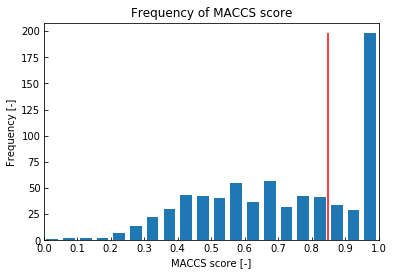

Percentage of score over 0.85: 35.75%


In [65]:
import matplotlib.pyplot as plt

max_maccs_scores = np.asarray([np.max(score) for score in maccs_scores])
frequency,ranges = np.histogram(max_maccs_scores,bins=20,range=(0.0,1.0))

plt.hist(max_maccs_scores,bins=20,range=(0.0,1.0),rwidth=0.7)
plt.vlines(0.85,0,np.max(frequency),'red')
plt.title("Frequency of MACCS score")
plt.xlim(0,1.0)
plt.xlabel('MACCS score [-]')
plt.ylabel('Frequency [-]')
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.show()

print("Percentage of score above 0.85: {:4.2f}%".format(np.average(max_maccs_scores > 0.85)*100))